# HSCT survival linear regression model

## Notebook set-up

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import probplot
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score

# Figure out if we are in a Kaggle notebook or not based on the current
# path and set file paths accordingly
if os.getcwd() == '/kaggle/working':
    print('Running on Kaggle')
    data_dictionary_file='/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv'
    training_data_file='/kaggle/input/equity-post-HCT-survival-predictions/train.csv'
    testing_data_file='/kaggle/input/equity-post-HCT-survival-predictions/test.csv'
    submission_file='submission.csv'

else:
    data_dictionary_file='../../data/raw/data_dictionary.csv'
    training_data_file='../../data/raw/train.csv'
    testing_data_file='../../data/raw/test.csv'
    submission_file='../predictions/linear_regression_submission.csv'

## 1. Load data

In [2]:
# Load the datasets
dictionary_df=pd.read_csv(data_dictionary_file)
training_df=pd.read_csv(training_data_file)
testing_df=pd.read_csv(testing_data_file)

# Save the ID and drop
testing_ids=testing_df['ID']
training_df.drop('ID', axis=1, inplace=True)
testing_df.drop('ID', axis=1, inplace=True)

# Extract the training labels
training_labels=training_df['efs_time']
training_df.drop(['efs', 'efs_time'], axis=1, inplace=True)

# Take the log of the labels
training_labels=np.log(training_labels)

print(f'Training features: {training_df.shape}')
print(f'Testing features: {testing_df.shape}')

Training features: (28800, 57)
Testing features: (3, 57)


## 2. Split categorical and numerical features

In [3]:
# Get lists of categorical and numerical column names
categorical_feature_names=dictionary_df['variable'][dictionary_df['type'] == 'Categorical']
numerical_feature_names=dictionary_df['variable'][dictionary_df['type'] == 'Numerical']

# Remove the feature column from the column names lists
categorical_feature_names=categorical_feature_names[categorical_feature_names != 'efs']
numerical_feature_names=numerical_feature_names[numerical_feature_names != 'efs_time']

# Split the training and testing dataframes
training_categorical_df=training_df[categorical_feature_names].copy()
training_numerical_df=training_df[numerical_feature_names].copy()
testing_categorical_df=testing_df[categorical_feature_names].copy()
testing_numerical_df=testing_df[numerical_feature_names].copy()

print(f'Training numerical features: {training_numerical_df.shape}')
print(f'Training categorical features: {training_categorical_df.shape}')
print(f'Testing numerical features: {testing_numerical_df.shape}')
print(f'Testing categorical features: {testing_categorical_df.shape}')

Training numerical features: (28800, 22)
Training categorical features: (28800, 35)
Testing numerical features: (3, 22)
Testing categorical features: (3, 35)


## 3. Handle missing data

### 3.1. Categorical features

In [4]:
training_categorical_df.fillna('Missing', inplace=True)
testing_categorical_df.fillna('Missing', inplace=True)

print(f'Training categorical features: {training_categorical_df.shape}')
print(f'Testing categorical features: {testing_categorical_df.shape}')

Training categorical features: (28800, 35)
Testing categorical features: (3, 35)


### 3.2. Numerical features

In [5]:
imputer=KNNImputer(n_neighbors=3, weights='uniform')
imputer.fit(training_numerical_df)

training_numerical_data=imputer.transform(training_numerical_df)
testing_numerical_data=imputer.transform(testing_numerical_df)

training_numerical_df=pd.DataFrame(training_numerical_data, columns=training_numerical_df.columns)
testing_numerical_df=pd.DataFrame(testing_numerical_data, columns=training_numerical_df.columns)

print(f'Training numerical features: {training_numerical_df.shape}')
print(f'Testing numerical features: {testing_numerical_df.shape}')

Training numerical features: (28800, 22)
Testing numerical features: (3, 22)


## 4. One-hot encode categorical features

In [6]:
# Encode the features
encoder=OneHotEncoder(drop='first', sparse_output=False)
encoder.fit(training_categorical_df)

training_categorical_data=encoder.transform(training_categorical_df)
testing_categorical_data=encoder.transform(testing_categorical_df)

# Rebuild the dataframes
feature_names=encoder.get_feature_names_out()
training_categorical_df=pd.DataFrame(training_categorical_data, columns=feature_names)
testing_categorical_df=pd.DataFrame(testing_categorical_data, columns=feature_names)

print(f'Training categorical features: {training_categorical_df.shape}')
print(f'Testing categorical features: {testing_categorical_df.shape}')

Training categorical features: (28800, 156)
Testing categorical features: (3, 156)


## 5. Re-combine numerical and categorical features

In [7]:
training_features_df=pd.concat(
    [
        training_numerical_df.reset_index(drop=True), 
        training_categorical_df.reset_index(drop=True)
    ],
    axis=1
)

testing_features_df=pd.concat(
    [
        testing_numerical_df.reset_index(drop=True), 
        testing_categorical_df.reset_index(drop=True)
    ],
    axis=1
)

print(f'Training features: {training_features_df.shape}')
print(f'Testing features: {testing_features_df.shape}')

Training features: (28800, 178)
Testing features: (3, 178)


## 5. Fit the model

### 5.1. Check training data performance

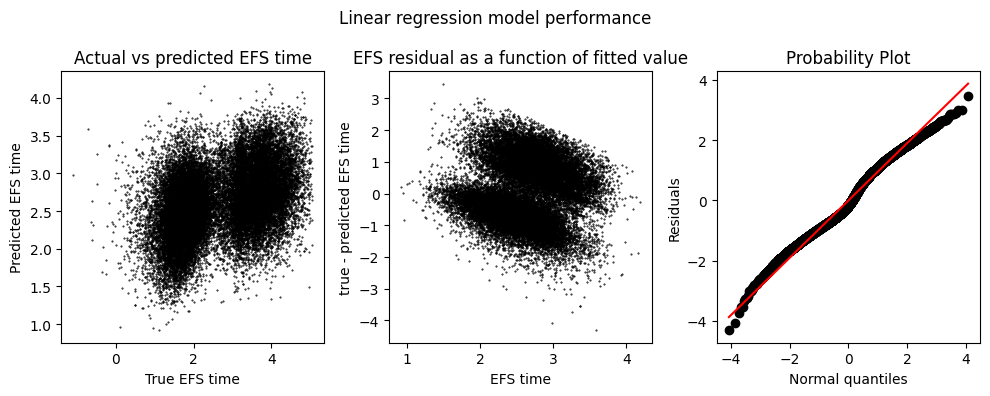

In [8]:
# Instantiate and train the model
model=LinearRegression()
model.fit(training_features_df, training_labels)

# Make predictions for the whole training set
predicted_efs_time=model.predict(training_features_df)

# Plot the results
fig, axs=plt.subplots(1,3, figsize=(10,4))
axs=axs.flatten()

fig.suptitle('Linear regression model performance')

axs[0].set_title('Actual vs predicted EFS time')
axs[0].scatter(training_labels, predicted_efs_time, color='black', s=0.2)
axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')

axs[1].set_title('EFS residual as a function of fitted value')
axs[1].scatter(predicted_efs_time, training_labels - predicted_efs_time, color='black', s=0.2)
axs[1].set_xlabel('EFS time')
axs[1].set_ylabel('true - predicted EFS time')

axs[2].set_title('Normal quantile plot')
probplot(training_labels - predicted_efs_time, plot=axs[2])
axs[2].get_lines()[0].set_markeredgecolor('black')
axs[2].get_lines()[0].set_markerfacecolor('black')
axs[2].set_xlabel('Normal quantiles')
axs[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

### 5.2. Estimate out-of-sample performance

In [9]:
# Define the cross-validation strategy
cross_validation=KFold(n_splits=7, shuffle=True, random_state=315)

# Run the cross-validation, collecting the scores
scores=cross_val_score(
    model,
    training_features_df,
    training_labels,
    cv=cross_validation,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

# Print mean and standard deviation of the scores
print(f'Cross validation RMSE {-scores.mean():.2f} +/- {scores.std():.2f}')

Cross validation RMSE 0.97 +/- 0.01


## 6. Make test set predictions

In [10]:
predicted_efs_time=model.predict(testing_features_df)
scaler=MinMaxScaler()
scaler.fit(predicted_efs_time.reshape(-1, 1))
predicted_efs_time=scaler.transform(predicted_efs_time.reshape(-1, 1))

predictions_df=pd.DataFrame.from_dict(
    {
        'ID': testing_ids,
        'prediction': predicted_efs_time.flatten()
    }
)

predictions_df.head()

,ID,prediction
0,28800,0.461272
1,28801,0.000000
2,28802,1.000000


In [11]:
predictions_df.to_csv(submission_file, index=False)